In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm  # For progress bars
import os
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as transforms
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
#cell 2
class JetDataset(Dataset):
    def __init__(self, file_path, transform=None, is_train=False):
        self.file_path = file_path
        self.transform = transform
        self.is_train = is_train
        with h5py.File(self.file_path, 'r') as f:
            self.length = f['jet'].shape[0]
            
            # Sampling a small subset to calculate statistics for normalization.
            # Sorting the indices so they are in increasing order.
            sample_indices = np.sort(np.random.choice(self.length, min(1000, self.length), replace=False))
            sample_data = f['jet'][sample_indices]
            self.means = np.mean(sample_data, axis=(0, 1, 2))
            self.stds = np.std(sample_data, axis=(0, 1, 2))
            
            # Replacing zero std with 1.0 to avoid division by zero
            self.stds = np.where(self.stds == 0, 1.0, self.stds)
            
            # Getting class balance from the corresponding labels
            sample_labels = f['label'][sample_indices]
            self.pos_weight = (len(sample_labels) - np.sum(sample_labels)) / np.sum(sample_labels)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            # Extracting data and label
            img = f['jet'][idx].astype(np.float32)
            label = f['label'][idx].astype(np.float32)
        
        # Converting from (H, W, C) to (C, H, W)
        img = np.transpose(img, (2, 0, 1))
        
        # Normalizing data using precomputed statistics
        for i in range(img.shape[0]):
            img[i] = (img[i] - self.means[i]) / self.stds[i]
        
        img_tensor = torch.tensor(img, dtype=torch.float32)
        
        # Applying transforms if provided (for data augmentation)
        if self.transform and self.is_train:
            img_tensor = self.transform(img_tensor)
        
        return img_tensor, torch.tensor(label, dtype=torch.float32)

#below function calculates class weights based on inverse frequency
def get_class_weights(dataset):
    
    targets = []
    with h5py.File(dataset.file_path, 'r') as f:
        if dataset.length > 10000:
            indices = np.random.choice(dataset.length, 10000, replace=False)
            targets = f['label'][indices]
        else:
            targets = f['label'][:]
    
    class_counts = np.bincount(targets.astype(int).flatten())
    class_weights = 1.0 / class_counts
    weights = class_weights[targets.astype(int).flatten()]
    return torch.from_numpy(weights).float()

# Defining data augmentation for training
train_transforms = transforms.Compose([
    # Spatial transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    # Intensity transformations
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])
train_path = "/teamspace/studios/this_studio/specific_task_2g/codes/splitted_data/train.h5"
val_path = "/teamspace/studios/this_studio/specific_task_2g/codes/splitted_data/val.h5"
test_path = "/teamspace/studios/this_studio/specific_task_2g/codes/splitted_data/test.h5"
train_dataset = JetDataset(train_path, transform=train_transforms, is_train=True)
val_dataset = JetDataset(val_path)
test_dataset = JetDataset(test_path)
# Calculating class weights for weighted sampling to handle imbalanced data
weights = get_class_weights(train_dataset)
sampler = WeightedRandomSampler(weights, len(weights))
# for verification
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Positive class weight: {train_dataset.pos_weight:.2f}")
# Creating a sample batch to check shapes
sample_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for images, labels in sample_loader:
    print(f"Input shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    print(f"Input range: min={images.min().item():.4f}, max={images.max().item():.4f}")
    break

Training samples: 8000
Validation samples: 1000
Test samples: 1000
Positive class weight: 18.23
Input shape: torch.Size([64, 8, 125, 125])
Label shape: torch.Size([64, 1])
Input range: min=-0.0355, max=261.7862


In [3]:
#below function creates residual block for the ResNet architecture
class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)
        
        return out

class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ImprovedJetResNet(nn.Module):
    def __init__(self, input_channels=8, dropout_rate=0.3):
        super(ImprovedJetResNet, self).__init__()
        
        # Initial convolution block
        self.initial = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks with SE attention
        self.layer1 = self._make_layer(64, 64, blocks=2)
        self.se1 = SEBlock(64)
        
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.se2 = SEBlock(128)
        
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.se3 = SEBlock(256)
        
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)
        self.se4 = SEBlock(512)
        
        # Global pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        
        # Multiple classifier heads for ensemble effect
        self.classifier1 = nn.Linear(512, 1)
        self.classifier2 = nn.Linear(512, 256)
        self.classifier2_2 = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )
        
        self.sigmoid = nn.Sigmoid()
        
        # Initializing weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride, downsample))
        
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.initial(x)
        
        x = self.layer1(x)
        x = self.se1(x)
        
        x = self.layer2(x)
        x = self.se2(x)
        
        x = self.layer3(x)
        x = self.se3(x)
        
        x = self.layer4(x)
        x = self.se4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        
        # Multi-head prediction
        out1 = self.classifier1(x)
        
        out2 = self.classifier2(x)
        out2 = self.classifier2_2(out2)
        
        # Averaging the predictions from different heads
        out = (out1 + out2) / 2.0
        
        return self.sigmoid(out)
# Creating model instance
model = ImprovedJetResNet(input_channels=8, dropout_rate=0.3)
model = model.to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

Model has 11,367,810 trainable parameters


In [4]:
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size*2,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size*2,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in validation: {len(val_loader)}")
print(f"Number of batches in testing: {len(test_loader)}")

Number of batches in training: 63
Number of batches in validation: 4
Number of batches in testing: 4


In [5]:
# Defining weighted loss function to handle class imbalance
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        
    def forward(self, output, target):
        # Calculate BCE loss
        loss = - (self.pos_weight * target * torch.log(output + 1e-7) + 
                 (1 - target) * torch.log(1 - output + 1e-7))
        return loss.mean()
criterion = WeightedBCELoss(pos_weight=train_dataset.pos_weight)
learning_rate = 3e-4
weight_decay = 1e-4 
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Defining learning rate scheduler with one-cycle policy
# I'll create the actual scheduler after defining the number of epochs
def get_one_cycle_scheduler(optimizer, max_lr, steps_per_epoch, epochs):
    total_steps = steps_per_epoch * epochs
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=max_lr,
        total_steps=total_steps,  # Using total_steps instead of steps_per_epoch and epochs
        pct_start=0.3,  # Spending 30% of time warming up
        anneal_strategy='cos',
        div_factor=25.0,  # initial_lr = max_lr/25
        final_div_factor=1000.0  # min_lr = initial_lr/1000
    )

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_targets = []
    pbar = tqdm(dataloader)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Applying mixup data augmentation with some probability
        if mixup_alpha > 0 and random.random() < 0.5:
            lam = np.random.beta(mixup_alpha, mixup_alpha)
            index = torch.randperm(inputs.size(0)).to(device)
            mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
            mixed_targets = lam * targets + (1 - lam) * targets[index]
            inputs = mixed_inputs
            targets = mixed_targets
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        # The scheduler.step() call will be moved to the training loop
        # to be called once per epoch instead of once per batch
        running_loss += loss.item() * inputs.size(0)
        binary_targets = torch.round(targets)
        predicted = (outputs > 0.5).float()
        total += targets.size(0)
        correct += (predicted == binary_targets).sum().item()
        
        # Storing outputs and targets for AUC calculation
        all_outputs.append(outputs.detach().cpu().numpy())
        all_targets.append(binary_targets.detach().cpu().numpy())
        pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100 * correct / total:.2f}%')
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    
    try:
        auc = roc_auc_score(all_targets, all_outputs)
    except:
        auc = 0.5
        print("Error in AUC calculation, defaulting to 0.5")
    
    return running_loss / total, correct / total, auc
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_targets = []
    
    # Disabling gradient computation for validation
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Storing outputs and targets for AUC calculation
            all_outputs.append(outputs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())
    
    # Calculating AUC
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    try:
        auc = roc_auc_score(all_targets, all_outputs)
    except:
        auc = 0.5
        print("Error in AUC calculation, defaulting to 0.5")
    
    return running_loss / total, correct / total, auc

In [7]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []
num_epochs = 50
# Creating the scheduler now that we know the number of epochs
scheduler = get_one_cycle_scheduler(
    optimizer,
    max_lr=learning_rate*10,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs
)
# Initializing the best performance tracking
best_val_auc = 0.0
best_val_acc = 0.0
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training with mixup
    train_loss, train_acc, train_auc = train_one_epoch(
        model, train_loader, criterion, optimizer, None, device, mixup_alpha=0.2
    )
    scheduler.step()
    
    # Validating
    val_loss, val_acc, val_auc = validate(model, val_loader, criterion, device)
    
    # Printing metrics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
    print("-" * 50)
    
    # Updating best performance
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_val_acc = val_acc
        # Saving model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
        }, 'best_model.pth')
    
    # Storing metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

# Finding the epoch with the highest validation AUC
best_epoch = np.argmax(val_aucs)
print(f"Best epoch: {best_epoch+1} with validation AUC: {val_aucs[best_epoch]:.4f}")
print(f"Best validation accuracy: {val_accs[best_epoch]:.4f}")

Epoch 1/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.9609, Train Acc: 0.9467, Train AUC: 0.9718
Val Loss: 1.9758, Val Acc: 0.4770, Val AUC: 0.7000
--------------------------------------------------
Epoch 2/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3514, Train Acc: 0.9297, Train AUC: 0.9817
Val Loss: 1.9297, Val Acc: 0.4770, Val AUC: 0.7149
--------------------------------------------------
Epoch 3/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3701, Train Acc: 0.9136, Train AUC: 0.9889
Val Loss: 1.9783, Val Acc: 0.4770, Val AUC: 0.6794
--------------------------------------------------
Epoch 4/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3557, Train Acc: 0.9219, Train AUC: 0.9881
Val Loss: 1.9330, Val Acc: 0.4770, Val AUC: 0.7779
--------------------------------------------------
Epoch 5/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3242, Train Acc: 0.9217, Train AUC: 0.9902
Val Loss: 1.8817, Val Acc: 0.4770, Val AUC: 0.7741
--------------------------------------------------
Epoch 6/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2987, Train Acc: 0.9345, Train AUC: 0.9922
Val Loss: 1.8517, Val Acc: 0.4770, Val AUC: 0.8078
--------------------------------------------------
Epoch 7/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3734, Train Acc: 0.9173, Train AUC: 0.9914
Val Loss: 1.8439, Val Acc: 0.4770, Val AUC: 0.8208
--------------------------------------------------
Epoch 8/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3522, Train Acc: 0.9147, Train AUC: 0.9931
Val Loss: 2.0523, Val Acc: 0.4770, Val AUC: 0.8184
--------------------------------------------------
Epoch 9/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3197, Train Acc: 0.9276, Train AUC: 0.9941
Val Loss: 1.7787, Val Acc: 0.4770, Val AUC: 0.8420
--------------------------------------------------
Epoch 10/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3454, Train Acc: 0.9367, Train AUC: 0.9928
Val Loss: 1.9049, Val Acc: 0.4830, Val AUC: 0.8677
--------------------------------------------------
Epoch 11/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2801, Train Acc: 0.9379, Train AUC: 0.9943
Val Loss: 1.9124, Val Acc: 0.4840, Val AUC: 0.8670
--------------------------------------------------
Epoch 12/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3304, Train Acc: 0.9287, Train AUC: 0.9947
Val Loss: 1.8128, Val Acc: 0.5000, Val AUC: 0.8763
--------------------------------------------------
Epoch 13/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3141, Train Acc: 0.9243, Train AUC: 0.9950
Val Loss: 2.2128, Val Acc: 0.6240, Val AUC: 0.8719
--------------------------------------------------
Epoch 14/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2785, Train Acc: 0.9330, Train AUC: 0.9961
Val Loss: 1.5713, Val Acc: 0.4960, Val AUC: 0.8921
--------------------------------------------------
Epoch 15/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2975, Train Acc: 0.9407, Train AUC: 0.9951
Val Loss: 1.5376, Val Acc: 0.6490, Val AUC: 0.8928
--------------------------------------------------
Epoch 16/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2415, Train Acc: 0.9436, Train AUC: 0.9965
Val Loss: 1.4974, Val Acc: 0.4830, Val AUC: 0.8860
--------------------------------------------------
Epoch 17/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2783, Train Acc: 0.9360, Train AUC: 0.9972
Val Loss: 2.9501, Val Acc: 0.7970, Val AUC: 0.8804
--------------------------------------------------
Epoch 18/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2273, Train Acc: 0.9546, Train AUC: 0.9967
Val Loss: 1.4241, Val Acc: 0.5920, Val AUC: 0.8982
--------------------------------------------------
Epoch 19/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2905, Train Acc: 0.9476, Train AUC: 0.9974
Val Loss: 2.2622, Val Acc: 0.6810, Val AUC: 0.8887
--------------------------------------------------
Epoch 20/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2625, Train Acc: 0.9457, Train AUC: 0.9964
Val Loss: 1.5194, Val Acc: 0.5570, Val AUC: 0.8678
--------------------------------------------------
Epoch 21/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2721, Train Acc: 0.9335, Train AUC: 0.9965
Val Loss: 1.6182, Val Acc: 0.4880, Val AUC: 0.8305
--------------------------------------------------
Epoch 22/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3581, Train Acc: 0.9185, Train AUC: 0.9954
Val Loss: 1.3484, Val Acc: 0.5240, Val AUC: 0.8980
--------------------------------------------------
Epoch 23/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2865, Train Acc: 0.9371, Train AUC: 0.9969
Val Loss: 1.4879, Val Acc: 0.7100, Val AUC: 0.8916
--------------------------------------------------
Epoch 24/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3004, Train Acc: 0.9196, Train AUC: 0.9970
Val Loss: 1.6225, Val Acc: 0.4820, Val AUC: 0.8546
--------------------------------------------------
Epoch 25/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2584, Train Acc: 0.9431, Train AUC: 0.9974
Val Loss: 1.4028, Val Acc: 0.6110, Val AUC: 0.8922
--------------------------------------------------
Epoch 26/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2709, Train Acc: 0.9381, Train AUC: 0.9980
Val Loss: 1.5661, Val Acc: 0.6900, Val AUC: 0.8934
--------------------------------------------------
Epoch 27/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3386, Train Acc: 0.9256, Train AUC: 0.9964
Val Loss: 1.4315, Val Acc: 0.6500, Val AUC: 0.8935
--------------------------------------------------
Epoch 28/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2092, Train Acc: 0.9581, Train AUC: 0.9979
Val Loss: 1.6851, Val Acc: 0.4920, Val AUC: 0.8831
--------------------------------------------------
Epoch 29/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2756, Train Acc: 0.9390, Train AUC: 0.9961
Val Loss: 1.8358, Val Acc: 0.8040, Val AUC: 0.9110
--------------------------------------------------
Epoch 30/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2443, Train Acc: 0.9524, Train AUC: 0.9972
Val Loss: 1.4331, Val Acc: 0.6530, Val AUC: 0.9047
--------------------------------------------------
Epoch 31/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2861, Train Acc: 0.9223, Train AUC: 0.9977
Val Loss: 1.4027, Val Acc: 0.5030, Val AUC: 0.8944
--------------------------------------------------
Epoch 32/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2780, Train Acc: 0.9316, Train AUC: 0.9979
Val Loss: 1.2491, Val Acc: 0.6500, Val AUC: 0.8995
--------------------------------------------------
Epoch 33/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2681, Train Acc: 0.9343, Train AUC: 0.9974
Val Loss: 1.7302, Val Acc: 0.7790, Val AUC: 0.9062
--------------------------------------------------
Epoch 34/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2245, Train Acc: 0.9516, Train AUC: 0.9974
Val Loss: 1.7304, Val Acc: 0.4840, Val AUC: 0.8538
--------------------------------------------------
Epoch 35/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2274, Train Acc: 0.9454, Train AUC: 0.9985
Val Loss: 1.4884, Val Acc: 0.5060, Val AUC: 0.9012
--------------------------------------------------
Epoch 36/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3134, Train Acc: 0.9231, Train AUC: 0.9979
Val Loss: 1.4349, Val Acc: 0.6420, Val AUC: 0.8930
--------------------------------------------------
Epoch 37/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2599, Train Acc: 0.9324, Train AUC: 0.9982
Val Loss: 1.6033, Val Acc: 0.7790, Val AUC: 0.9115
--------------------------------------------------
Epoch 38/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2955, Train Acc: 0.9340, Train AUC: 0.9954
Val Loss: 1.8299, Val Acc: 0.7900, Val AUC: 0.9108
--------------------------------------------------
Epoch 39/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2330, Train Acc: 0.9579, Train AUC: 0.9984
Val Loss: 2.9223, Val Acc: 0.8430, Val AUC: 0.9106
--------------------------------------------------
Epoch 40/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2210, Train Acc: 0.9505, Train AUC: 0.9981
Val Loss: 1.7095, Val Acc: 0.7740, Val AUC: 0.9118
--------------------------------------------------
Epoch 41/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3134, Train Acc: 0.9306, Train AUC: 0.9974
Val Loss: 1.7070, Val Acc: 0.7660, Val AUC: 0.9050
--------------------------------------------------
Epoch 42/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2054, Train Acc: 0.9580, Train AUC: 0.9983
Val Loss: 1.9164, Val Acc: 0.8350, Val AUC: 0.9052
--------------------------------------------------
Epoch 43/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2686, Train Acc: 0.9317, Train AUC: 0.9980
Val Loss: 1.1282, Val Acc: 0.6910, Val AUC: 0.9141
--------------------------------------------------
Epoch 44/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2238, Train Acc: 0.9459, Train AUC: 0.9985
Val Loss: 2.5348, Val Acc: 0.8230, Val AUC: 0.8987
--------------------------------------------------
Epoch 45/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3153, Train Acc: 0.9260, Train AUC: 0.9979
Val Loss: 1.4276, Val Acc: 0.5620, Val AUC: 0.8780
--------------------------------------------------
Epoch 46/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3436, Train Acc: 0.9253, Train AUC: 0.9969
Val Loss: 1.1832, Val Acc: 0.7390, Val AUC: 0.9130
--------------------------------------------------
Epoch 47/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2280, Train Acc: 0.9459, Train AUC: 0.9988
Val Loss: 2.2962, Val Acc: 0.8530, Val AUC: 0.9121
--------------------------------------------------
Epoch 48/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.2546, Train Acc: 0.9406, Train AUC: 0.9982
Val Loss: 5.1788, Val Acc: 0.8250, Val AUC: 0.9193
--------------------------------------------------
Epoch 49/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3187, Train Acc: 0.9299, Train AUC: 0.9977
Val Loss: 2.7885, Val Acc: 0.8420, Val AUC: 0.9076
--------------------------------------------------
Epoch 50/50


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.3018, Train Acc: 0.9221, Train AUC: 0.9977
Val Loss: 1.3642, Val Acc: 0.8000, Val AUC: 0.9155
--------------------------------------------------
Best epoch: 48 with validation AUC: 0.9193
Best validation accuracy: 0.8250


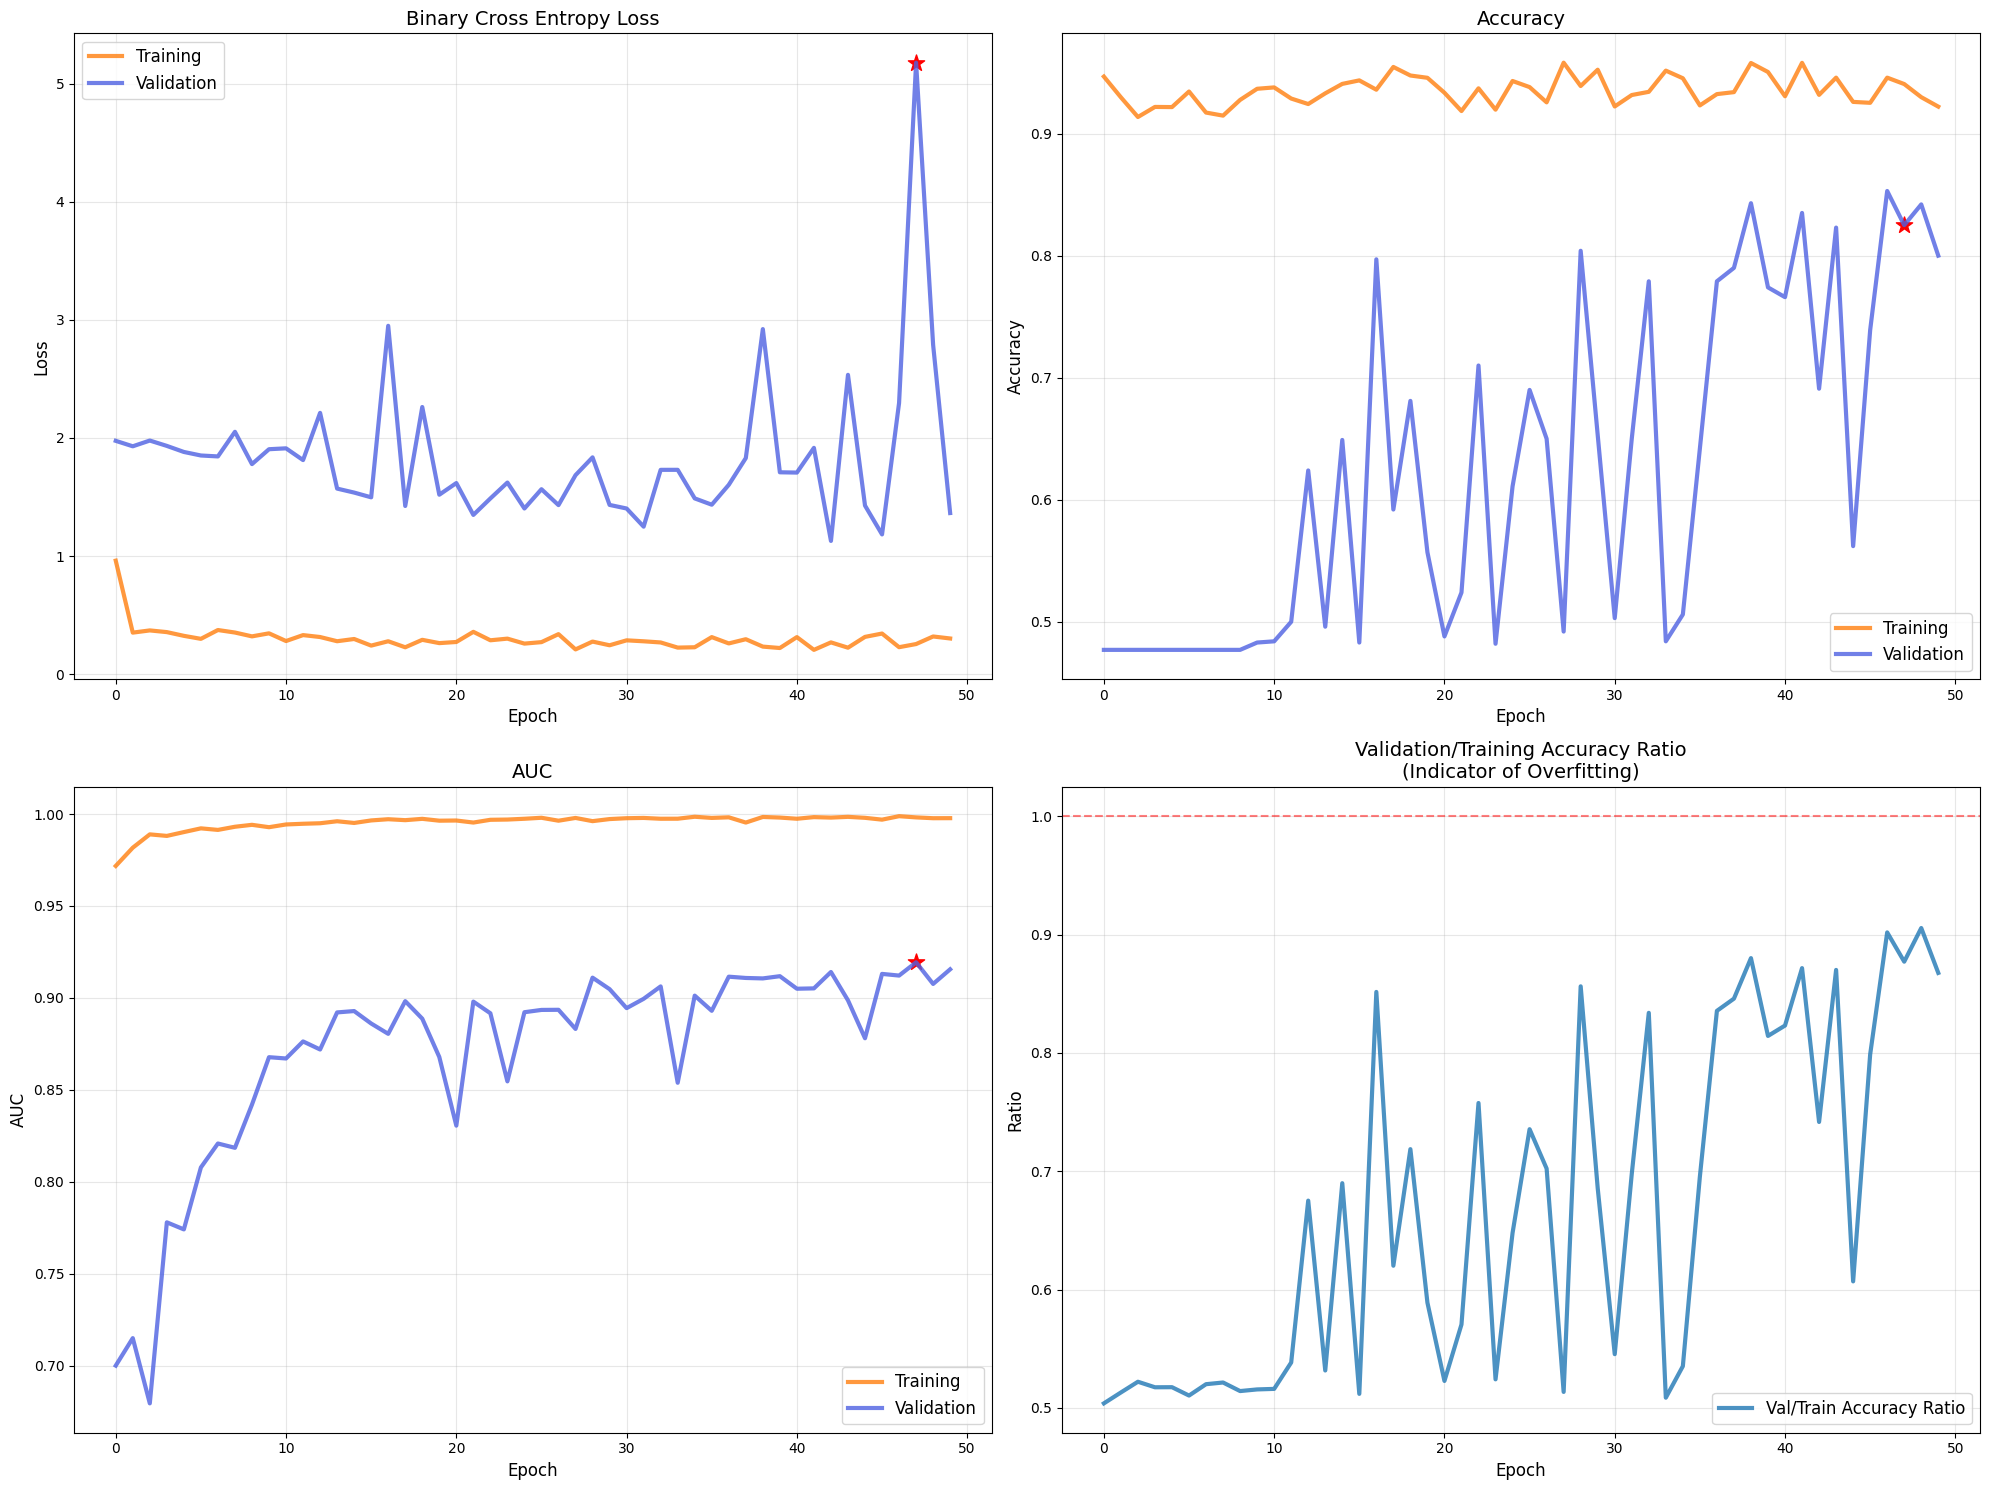

In [10]:
# Plotting losses
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(val_losses, label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.scatter(best_epoch, val_losses[best_epoch], s=150, c='red', marker='*')
plt.title('Binary Cross Entropy Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
# Plotting accuracies
plt.subplot(2, 2, 2)
plt.plot(train_accs, label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(val_accs, label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.scatter(best_epoch, val_accs[best_epoch], s=150, c='red', marker='*')
plt.title('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
# Plotting AUC
plt.subplot(2, 2, 3)
plt.plot(train_aucs, label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(val_aucs, label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.scatter(best_epoch, val_aucs[best_epoch], s=150, c='red', marker='*')
plt.title('AUC', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
# Plotting learning rate
plt.subplot(2, 2, 4)
plt.plot(np.linspace(0, len(train_losses)-1, num=len(train_losses)), 
         [val_accs[i]/train_accs[i] for i in range(len(train_accs))], 
         label='Val/Train Accuracy Ratio', 
         alpha=0.8, linewidth=3)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
plt.title('Validation/Training Accuracy Ratio\n(Indicator of Overfitting)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Loaded best model from epoch 48 with validation AUC: 0.9193


  0%|          | 0/4 [00:00<?, ?it/s]

Test Loss: 6.1648
Test Accuracy: 0.8060
Test AUC: 0.8987


  0%|          | 0/4 [00:00<?, ?it/s]

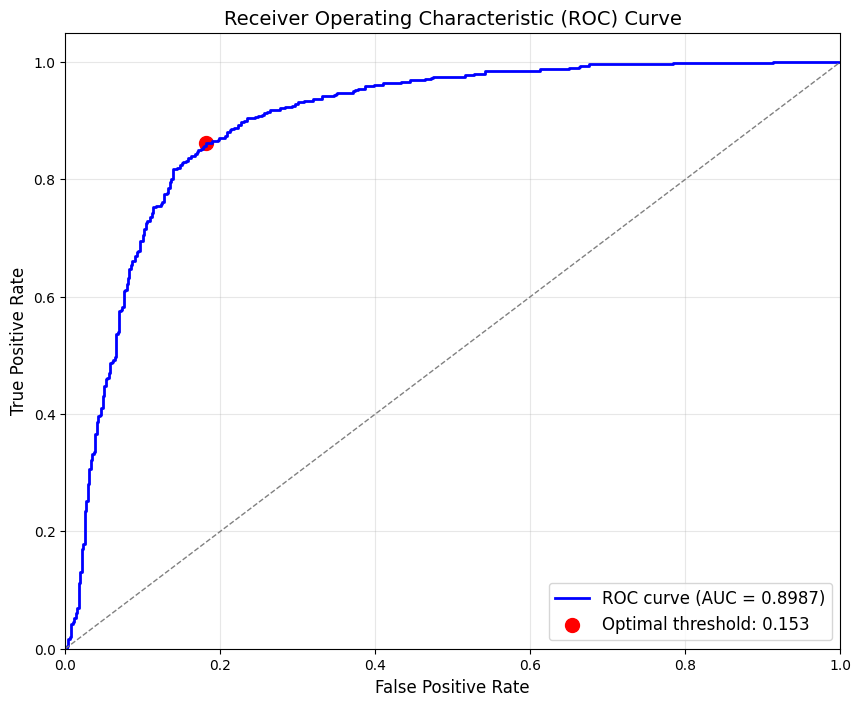

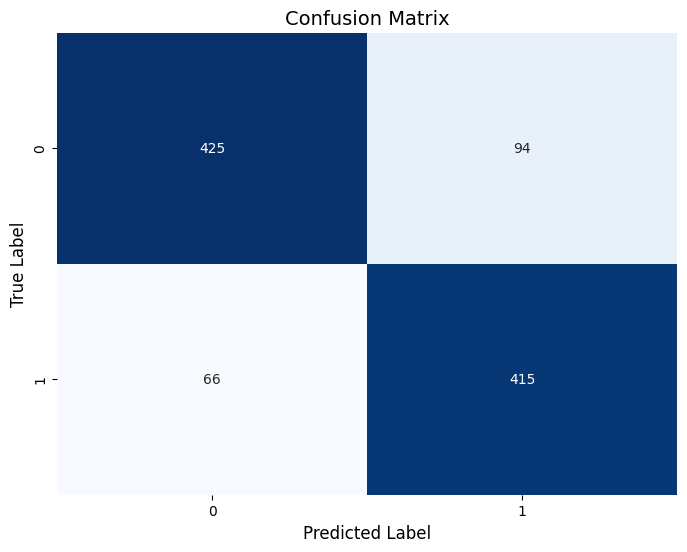

Optimal threshold: 0.1532
Precision: 0.8153
Recall/Sensitivity: 0.8628
Specificity: 0.8189
F1 Score: 0.8384


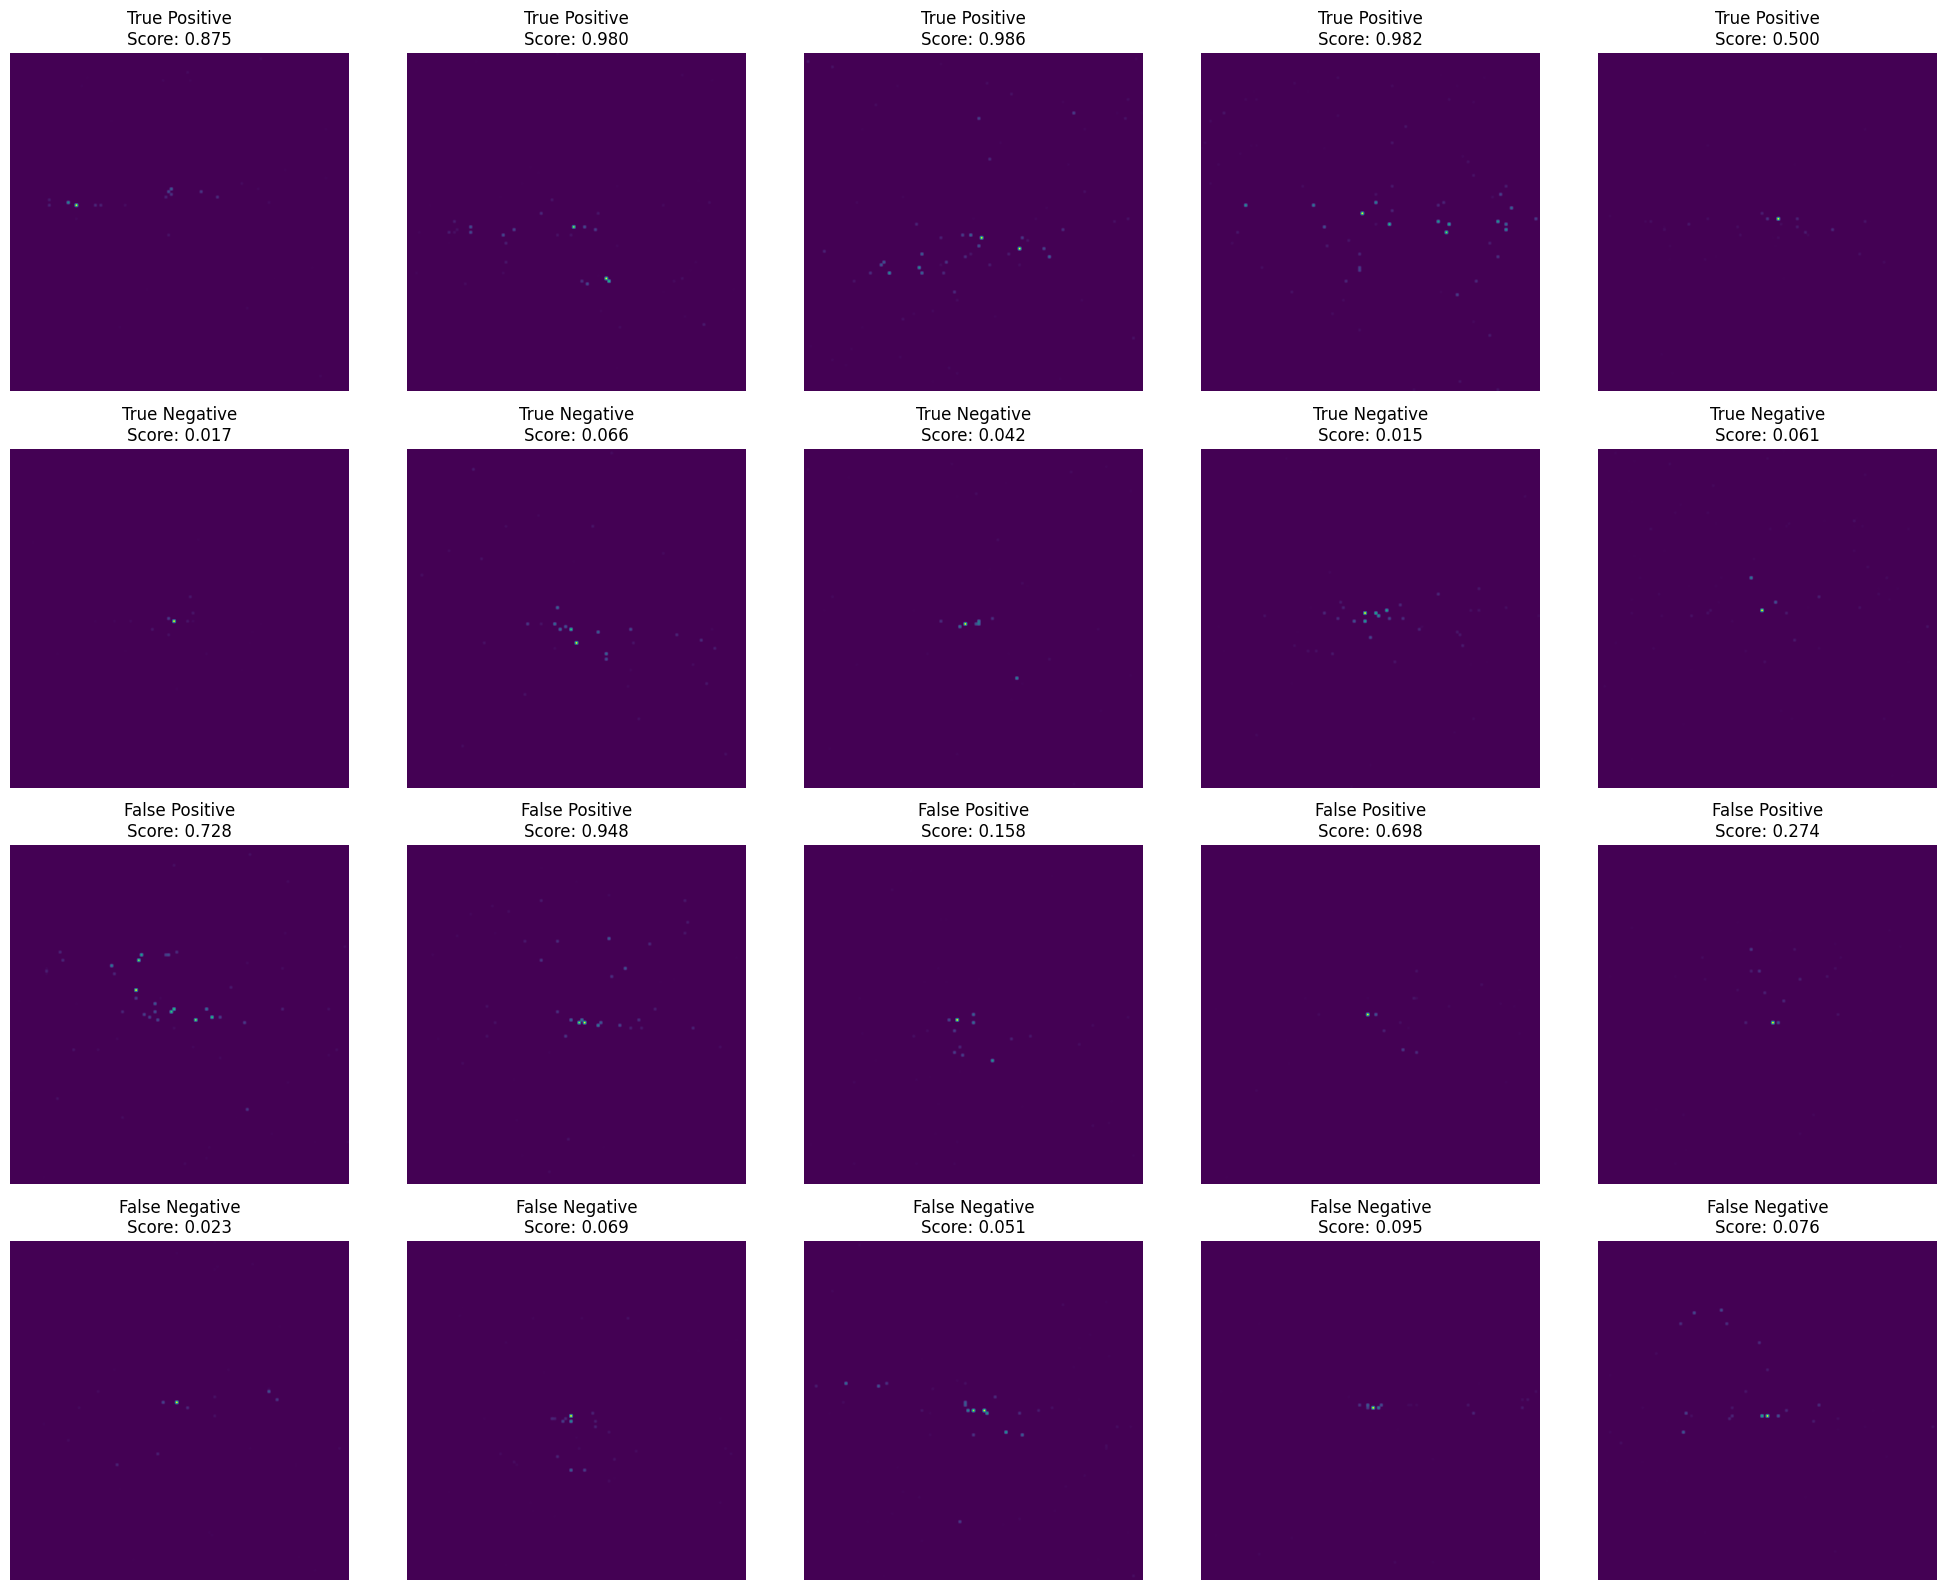


Final Model Performance:
----------------------------------------
Test Accuracy: 0.8060
Test AUC: 0.8987
F1 Score: 0.8384
Precision: 0.8153
Recall: 0.8628
----------------------------------------

Model Architecture:
----------------------------------------
ImprovedJetResNet(
  (initial): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

In [11]:
# Loading the best model
checkpoint = torch.load('/teamspace/studios/this_studio/specific_task_2g/codes/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with validation AUC: {checkpoint['val_auc']:.4f}")
# Evaluating on test set
test_loss, test_acc, test_auc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
# Performing more detailed evaluation
def detailed_evaluation(model, dataloader, device):
    model.eval()
    all_outputs = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    all_outputs = np.concatenate(all_outputs).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    
    # Calculating ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
    
    # Finding the optimal threshold (closest to top-left corner)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculating confusion matrix with optimal threshold
    predictions = (all_outputs >= optimal_threshold).astype(int)
    cm = confusion_matrix(all_targets, predictions)
    
    # Plotting ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', s=100, marker='o', 
              label=f'Optimal threshold: {optimal_threshold:.3f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()
    
    # Calculating and print additional metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    specificity = tn / (tn + fp)
    
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'threshold': optimal_threshold,
        'auc': test_auc,
        'accuracy': test_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr
    }

# Running detailed evaluation
results = detailed_evaluation(model, test_loader, device)

# Optionally, visualizing some examples of predictions
def visualize_examples(model, dataloader, device, num_examples=5):
    model.eval()
    examples_seen = 0
    true_positives = []
    true_negatives = []
    false_positives = []
    false_negatives = []
    
    # Collecting examples
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = (outputs >= results['threshold']).float()
            
            # Finding examples of each case
            for i in range(len(targets)):
                case = None
                if targets[i] == 1 and predictions[i] == 1:
                    if len(true_positives) < num_examples:
                        true_positives.append((inputs[i].cpu(), outputs[i].item()))
                        case = "TP"
                elif targets[i] == 0 and predictions[i] == 0:
                    if len(true_negatives) < num_examples:
                        true_negatives.append((inputs[i].cpu(), outputs[i].item()))
                        case = "TN"
                elif targets[i] == 0 and predictions[i] == 1:
                    if len(false_positives) < num_examples:
                        false_positives.append((inputs[i].cpu(), outputs[i].item()))
                        case = "FP"
                elif targets[i] == 1 and predictions[i] == 0:
                    if len(false_negatives) < num_examples:
                        false_negatives.append((inputs[i].cpu(), outputs[i].item()))
                        case = "FN"
                
                if case is not None:
                    examples_seen += 1
            
            # Checking if we have enough examples
            if (len(true_positives) >= num_examples and 
                len(true_negatives) >= num_examples and 
                len(false_positives) >= num_examples and 
                len(false_negatives) >= num_examples):
                break
    
    # Visualizing examples
    fig, axes = plt.subplots(4, num_examples, figsize=(num_examples*4, 16))
    
    def plot_example(ax, example, title):
        img, score = example
        img = img.numpy()
        
        # Taking the first channel for visualization
        display_img = img[0]  # Using the first channel
        display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
        
        ax.imshow(display_img, cmap='viridis')
        ax.set_title(f"{title}\nScore: {score:.3f}")
        ax.axis('off')
    
    # Plotting examples for each category
    for i in range(min(num_examples, len(true_positives))):
        plot_example(axes[0, i], true_positives[i], "True Positive")
    
    for i in range(min(num_examples, len(true_negatives))):
        plot_example(axes[1, i], true_negatives[i], "True Negative")
    
    for i in range(min(num_examples, len(false_positives))):
        plot_example(axes[2, i], false_positives[i], "False Positive")
    
    for i in range(min(num_examples, len(false_negatives))):
        plot_example(axes[3, i], false_negatives[i], "False Negative")
    
    plt.tight_layout()
    plt.show()
# Visualizing example predictions
visualize_examples(model, test_loader, device, num_examples=5)
# Printing final summary of model performance
print("\nFinal Model Performance:")
print("-" * 40)
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC: {results['auc']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print("-" * 40)
# Saving final results
results_dict = {
    'test_accuracy': results['accuracy'],
    'test_auc': results['auc'],
    'f1_score': results['f1'],
    'precision': results['precision'],
    'recall': results['recall'],
    'specificity': results['specificity'],
    'optimal_threshold': results['threshold']
}
# Printing model architecture summary
print("\nModel Architecture:")
print("-" * 40)
print(model)
print("-" * 40)
print("Evaluation complete!")